<a href="https://colab.research.google.com/github/harshi1707/FinalProject/blob/main/Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === CELL 0: Notes & quick config ===
# Paste this notebook into Colab and run cells from top to bottom.
# Configure below:
USE_BIGQUERY = False      # True -> fetch Ethereum transactions from BigQuery (requires service account JSON)
ELLIPTIC_FALLBACK = True  # True -> download Elliptic dataset if no BigQuery
SAMPLE_STRATEGY = "top_n" # "top_n", "neighborhood", "random"
N_TOP = 50000             # for top_n sampling
NEIGHBORHOOD_SEED_WALLETS = []  # list of known wallets if using neighborhood strategy
RANDOM_SEED = 42
# Model/train tuning (demo values; change for real runs)
GNN_EPOCHS = 8
HYBRID_EPOCHS = 8
TEMP_EPOCHS = 6
BATCH_SIZE = 2048

# If using BigQuery, upload service account json and set path:
BQ_SERVICE_ACCOUNT_JSON = "service_account.json"  # upload to Colab via files.upload() if needed

# For speed in demo: reduce sizes
MAX_EDGES_FOR_DEMO = 200000  # adjust to limit memory

In [ ]:
# === CELL 1: Basic installs (PyTorch, PyG, helpers)
# This cell tries to install packages robustly in Colab. It may take a few minutes.
# If wheel-based PyG install fails, re-run with correct torch/cuda versions per https://pytorch-geometric.readthedocs.io/
import sys, subprocess, math, os

# Upgrade pip
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip", "wheel"], stdout=subprocess.DEVNULL)

# Basic libs
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "numpy", "pandas", "matplotlib", "scikit-learn", "networkx", "pyvis", "plotly", "tqdm", "google-cloud-bigquery", "kaggle"], stdout=subprocess.DEVNULL)

# Try to rely on existing torch in Colab; if missing, install CPU or default GPU torch
try:
    import torch
    print("Found torch", torch.__version__)
except Exception:
    print("Torch not found, installing cpu torch...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torch", "torchvision", "torchaudio"], stdout=subprocess.DEVNULL)
    import torch

TORCH = torch.__version__.split('+')[0]
CUDA = 'cpu' if torch.version.cuda is None else 'cu' + torch.version.cuda.replace('.', '')
print("Torch:", TORCH, "CUDA tag:", CUDA)

# Attempt to install matching PyG wheels from data.pyg.org
PYG_INDEX = f"https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html"
print("Attempting to install PyG from:", PYG_INDEX)
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--find-links", PYG_INDEX,
                           "torch_scatter", "torch_sparse", "torch_cluster", "torch_spline_conv"], stdout=subprocess.DEVNULL)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torch_geometric"], stdout=subprocess.DEVNULL)
    print("Installed PyG dependencies & torch_geometric.")
except Exception as e:
    print("PyG wheel install may have failed (often depending on CUDA). Trying fallback 'pip install torch_geometric' ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torch_geometric"], stdout=subprocess.DEVNULL)

# Install torch_geometric_temporal optionally
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "torch_geometric_temporal"], stdout=subprocess.DEVNULL)
# Install other ML libs
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pyyaml", "protobuf"], stdout=subprocess.DEVNULL)

print("Install step finished. Please restart runtime if imports fail.")


Found torch 2.8.0+cu126
Torch: 2.8.0 CUDA tag: cu126
Attempting to install PyG from: https://data.pyg.org/whl/torch-2.8.0+cu126.html
Installed PyG dependencies & torch_geometric.
Install step finished. Please restart runtime if imports fail.


In [ ]:
# === CELL 2: Imports and reproducibility ===
import os, random, math, time, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import sklearn
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.utils import k_hop_subgraph, to_networkx
from torch_geometric.nn import SAGEConv, GATConv
from torch_geometric.data import TemporalData

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
# === CELL 3: Download / load datasets
# - Elliptic dataset from Kaggle is used as a labeled graph example (GNN training).
# - Optionally pull Ethereum transaction slice from BigQuery (requires credentials).
# This cell builds 'sampled' DataFrame when USE_BIGQUERY True; otherwise loads Elliptic features.

if USE_BIGQUERY:
    print("Attempting to load Ethereum transactions from BigQuery. Make sure you've uploaded service account JSON to Colab and set GOOGLE_APPLICATION_CREDENTIALS.")
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = BQ_SERVICE_ACCOUNT_JSON
    from google.cloud import bigquery
    client = bigquery.Client()
    query = f"""
    SELECT LOWER(from_address) AS src, LOWER(to_address) AS dst, block_timestamp AS ts,
           SAFE_DIVIDE(value, 1e18) AS eth_value
    FROM `bigquery-public-data.crypto_ethereum.transactions`
    WHERE block_timestamp BETWEEN TIMESTAMP('2024-01-01') AND TIMESTAMP('2024-12-31')
      AND from_address IS NOT NULL
      AND to_address IS NOT NULL
    LIMIT {MAX_EDGES_FOR_DEMO}
    """
    df = client.query(query).to_dataframe()
    print("BigQuery sample shape:", df.shape)
    sampled = df.copy()
else:
    # Use Elliptic dataset as fallback demo (node classification)
    print("Loading Elliptic dataset (PyG)...")
    ds_root = "data/elliptic/pyg"
    dataset = EllipticBitcoinDataset(root="data/elliptic")
    d = dataset[0]
    print("Elliptic data loaded: nodes", d.num_nodes, "edges", d.num_edges)
    # Load raw feature & edge CSVs (they are in dataset directory if you downloaded earlier)
    BASE = "data/elliptic/elliptic_bitcoin_dataset"
    feat_path = f"{BASE}/elliptic_txs_features.csv"
    edge_path = f"{BASE}/elliptic_txs_edgelist.csv"
    class_path = f"{BASE}/elliptic_txs_classes.csv"
    if os.path.exists(feat_path) and os.path.exists(edge_path):
        feat_df = pd.read_csv(feat_path, header=None)
        feat_df = feat_df.rename(columns={0:"txId", 1:"time_step"})
        edge_df = pd.read_csv(edge_path)
        class_df = pd.read_csv(class_path)
        print("Loaded Elliptic CSVs:", feat_df.shape, edge_df.shape, class_df.shape)
    else:
        print("Elliptic CSVs not found locally. PyG loader still provided 'data' object.")
    # We'll also produce a 'sampled' DataFrame from edge_df if available, with synthetic eth_value
    if 'edge_df' in globals():
        # Construct a minimal sampled table: use txId integers as addresses (stringified)
        sampled = edge_df.rename(columns={edge_df.columns[0]:'src', edge_df.columns[1]:'dst'})
        sampled['ts'] = np.random.randint(1_700_000_000, 1_700_100_000, size=len(sampled))
        sampled['eth_value'] = np.random.lognormal(mean=0.0, sigma=1.0, size=len(sampled))
        # Map txId ints to strings to imitate addresses
        sampled['src'] = sampled['src'].astype(str)
        sampled['dst'] = sampled['dst'].astype(str)
        sampled = sampled[['src','dst','ts','eth_value']]
        print("Constructed sampled from elliptic edges:", sampled.shape)
    else:
        # fallback synthetic
        n_nodes = 2000
        n_edges = 20000
        rng = np.random.default_rng(RANDOM_SEED)
        s = rng.choice(n_nodes, size=n_edges)
        d_arr = rng.choice(n_nodes, size=n_edges)
        t = np.arange(n_edges) + 1_700_000_000
        vals = rng.lognormal(mean=0.0, sigma=1.0, size=n_edges)
        sampled = pd.DataFrame({'src': [f"0x{v:040d}" for v in s],
                                'dst': [f"0x{v:040d}" for v in d_arr],
                                'ts': pd.to_datetime(t, unit='s'),
                                'eth_value': vals})
        print("Created synthetic sampled:", sampled.shape)


Loading Elliptic dataset (PyG)...


Processing...


Elliptic data loaded: nodes 203769 edges 234355
Elliptic CSVs not found locally. PyG loader still provided 'data' object.
Created synthetic sampled: (20000, 4)


Done!


In [ ]:
# === CELL 4: Sampling strategies (top_n, neighborhood, random) & mapping to IDs ===
# Outputs: sampled_small, addr2id, n_nodes
print("Original sampled shape:", sampled.shape)
if SAMPLE_STRATEGY == "top_n":
    N = N_TOP
    all_addrs = pd.concat([sampled['src'], sampled['dst']])
    top_addrs = all_addrs.value_counts().head(N).index
    sampled_small = sampled[(sampled['src'].isin(top_addrs)) & (sampled['dst'].isin(top_addrs))].copy()
    print(f"[top_n] filtered edges: {sampled_small.shape}")
elif SAMPLE_STRATEGY == "neighborhood" and len(NEIGHBORHOOD_SEED_WALLETS)>0:
    # Build adjacency dict
    adj = {}
    for _, row in sampled.iterrows():
        adj.setdefault(row['src'], set()).add(row['dst'])
        adj.setdefault(row['dst'], set()).add(row['src'])
    radius = 2
    seed = set(NEIGHBORHOOD_SEED_WALLETS)
    frontier = set(seed)
    selected = set(seed)
    for _ in range(radius):
        nf = set()
        for w in frontier:
            nf |= adj.get(w, set())
        nf -= selected
        selected |= nf
        frontier = nf
    sampled_small = sampled[(sampled['src'].isin(selected)) & (sampled['dst'].isin(selected))].copy()
    print(f"[neighborhood] filtered edges: {sampled_small.shape}")
elif SAMPLE_STRATEGY == "random":
    n = min(len(sampled), MAX_EDGES_FOR_DEMO)
    sampled_small = sampled.sample(n=n, random_state=RANDOM_SEED).copy()
    print(f"[random] sampled edges: {sampled_small.shape}")
else:
    print("Strategy unknown or neighborhood seeds empty; defaulting to top_n small N=5000")
    sampled_small = sampled.sample(n=min(5000, len(sampled)), random_state=RANDOM_SEED).copy()

# sanitize timestamps
if 'ts' in sampled_small.columns and not np.issubdtype(sampled_small['ts'].dtype, np.datetime64):
    try:
        sampled_small['ts'] = pd.to_datetime(sampled_small['ts'])
    except Exception:
        sampled_small['ts'] = pd.to_datetime(sampled_small['ts'], unit='s', errors='coerce')
# map addresses to integer node ids
addrs = pd.Index(pd.unique(sampled_small[['src','dst']].values.ravel()))
addr2id = {a:i for i,a in enumerate(addrs)}
sampled_small['src_id'] = sampled_small['src'].map(addr2id)
sampled_small['dst_id'] = sampled_small['dst'].map(addr2id)
n_nodes = len(addrs)
print("After sampling: nodes:", n_nodes, "edges:", len(sampled_small))


Original sampled shape: (20000, 4)
[top_n] filtered edges: (20000, 4)
After sampling: nodes: 2000 edges: 20000


In [ ]:
# === CELL 5: Build PyG Data (static graph) and TemporalData (temporal edge stream) ===
import torch
# Build static edge_index
edge_index = torch.tensor([sampled_small['src_id'].values, sampled_small['dst_id'].values], dtype=torch.long)
# Node features: simple engineered (deg_in, deg_out, total_value)
n_nodes = int(edge_index.max().item()+1) if edge_index.numel()>0 else n_nodes
deg_in = np.zeros(n_nodes, dtype=np.float32)
deg_out = np.zeros(n_nodes, dtype=np.float32)
val_sum = np.zeros(n_nodes, dtype=np.float32)
for s,d,v in zip(sampled_small['src_id'].values, sampled_small['dst_id'].values, sampled_small['eth_value'].astype(float).values):
    deg_out[int(s)] += 1.0
    deg_in[int(d)] += 1.0
    val_sum[int(s)] += float(v)
    val_sum[int(d)] += float(v)
x = torch.tensor(np.stack([deg_in, deg_out, val_sum], axis=1), dtype=torch.float)
data_static = Data(x=x, edge_index=edge_index)
print("Static Data:", data_static)

# TemporalData (ordered by time)
sampled_small = sampled_small.sort_values('ts').reset_index(drop=True)
src = torch.tensor(sampled_small['src_id'].values, dtype=torch.long)
dst = torch.tensor(sampled_small['dst_id'].values, dtype=torch.long)
# convert timestamps to unix seconds
if np.issubdtype(sampled_small['ts'].dtype, np.datetime64):
    ts_unix = sampled_small['ts'].astype('int64')//10**9
else:
    ts_unix = pd.to_datetime(sampled_small['ts']).astype('int64')//10**9
t = torch.tensor(ts_unix.values, dtype=torch.long)
msg = torch.tensor(np.log1p(sampled_small['eth_value'].astype(float).values).reshape(-1,1).astype(np.float32))
td = TemporalData(src=src, dst=dst, t=t, msg=msg)
print("TemporalData built:", td)


Static Data: Data(x=[2000, 3], edge_index=[2, 20000])
TemporalData built: TemporalData(src=[20000], dst=[20000], t=[20000], msg=[20000, 1])


/tmp/ipython-input-2002506114.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  edge_index = torch.tensor([sampled_small['src_id'].values, sampled_small['dst_id'].values], dtype=torch.long)


Nodes: 2000 Edges: 20000


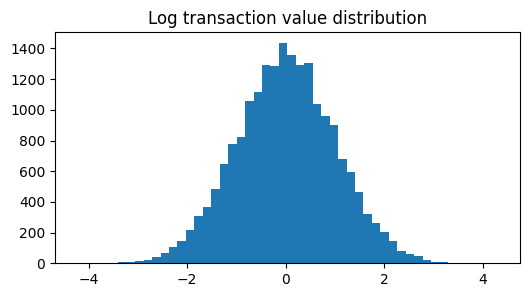

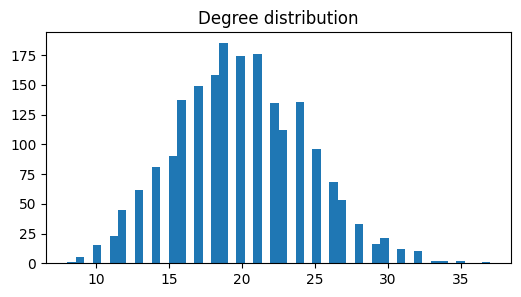

In [ ]:
# === CELL 6: EDA & basic visualizations ===
print("Nodes:", data_static.num_nodes, "Edges:", data_static.num_edges)
plt.figure(figsize=(6,3))
plt.hist(sampled_small['eth_value'].clip(1e-6).apply(np.log), bins=50)
plt.title("Log transaction value distribution")
plt.show()

# degree histogram
Gtmp = nx.from_pandas_edgelist(sampled_small[['src_id','dst_id']].rename(columns={'src_id':'u','dst_id':'v'}), source='u', target='v', create_using=nx.DiGraph)
deg = np.array([d for _,d in Gtmp.degree()])
plt.figure(figsize=(6,3))
plt.hist(deg, bins=50)
plt.title("Degree distribution")
plt.show()


In [ ]:
# === CELL 7: Temporal sequence builder per node for LSTM/GRU/Transformer inputs ===
# Build per-node sequences of recent interactions. Each element: [log_value, delta_ts_hours, direction]
SEQ_LEN = 32
def build_node_sequences(df, n_nodes, L=SEQ_LEN):
    seqs = {i: [] for i in range(n_nodes)}
    base_ts = pd.to_datetime(df['ts']).astype('int64')//10**9
    for _, row in df.iterrows():
        s = int(row['src_id']); d = int(row['dst_id'])
        ts = int(pd.to_datetime(row['ts']).value // 10**9) if np.issubdtype(type(row['ts']), np.datetime64) or isinstance(row['ts'], pd.Timestamp) else int(row['ts'])
        val = float(row['eth_value'])
        entry_out = [math.log1p(val), ts, 1.0]  # outgoing
        entry_in = [math.log1p(val), ts, 0.0]   # incoming
        seqs[s].append(entry_out)
        seqs[d].append(entry_in)
    # convert to fixed-length arrays and normalize delta time
    X = []
    for nid in range(n_nodes):
        hist = sorted(seqs[nid], key=lambda x: x[1])[-L:]
        if len(hist)==0:
            arr = np.zeros((L,3), dtype=np.float32)
        else:
            arr = np.array(hist, dtype=np.float64)
            # compute delta hours from last event
            if arr.shape[0] > 1:
                last_ts = arr[:,1]
                # represent timestamps as difference to last event in hours (so last is 0)
                deltas = (last_ts.max() - last_ts)/3600.0
                arr[:,1] = deltas
            else:
                arr[:,1] = 0.0
            if arr.shape[0] < L:
                pad = np.zeros((L-arr.shape[0], 3))
                arr = np.vstack([pad, arr])
        # normalize columns: val (log) and delta (hours) feature scale per-node is okay for demo (global scaling can be added)
        X.append(arr.astype(np.float32))
    X = np.stack(X, axis=0)  # [N, L, 3]
    return torch.tensor(X, dtype=torch.float32)
seq_tensor = build_node_sequences(sampled_small, n_nodes, L=SEQ_LEN).to(device)
print("Sequence tensor shape:", seq_tensor.shape)  # [N, L, F]


Sequence tensor shape: torch.Size([2000, 32, 3])


In [ ]:
# === CELL 8: Define models
import torch.nn as nn

# ----- Temporal encoders -----
class LSTMEncoder(nn.Module):
    def __init__(self, in_dim, hid=64, nlayers=1, bidir=False):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, nlayers, batch_first=True, bidirectional=bidir)
        self.out_dim = hid * (2 if bidir else 1)
    def forward(self, x):
        out, (h, c) = self.lstm(x)
        if self.lstm.bidirectional:
            h_last = torch.cat([h[-2], h[-1]], dim=-1)
        else:
            h_last = h[-1]
        return h_last

class GRUEncoder(nn.Module):
    def __init__(self, in_dim, hid=64, nlayers=1, bidir=False):
        super().__init__()
        self.gru = nn.GRU(in_dim, hid, nlayers, batch_first=True, bidirectional=bidir)
        self.out_dim = hid * (2 if bidir else 1)
    def forward(self, x):
        out, h = self.gru(x)
        if self.gru.bidirectional:
            return torch.cat([h[-2], h[-1]], dim=-1)
        return h[-1]

class TransformerEncoderSmall(nn.Module):
    def __init__(self, in_dim, model_dim=64, nhead=4, nlayers=2):
        super().__init__()
        self.proj = nn.Linear(in_dim, model_dim)
        enc_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.cls = nn.Parameter(torch.randn(1,1,model_dim)*0.01)
        self.out_dim = model_dim
    def forward(self, x):
        B = x.size(0)
        x = self.proj(x)
        cls = self.cls.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        x = self.encoder(x)
        return x[:,0]

# ----- Graph models -----
class SageNet(nn.Module):
    def __init__(self, in_dim, hid=128, out=2):
        super().__init__()
        self.c1 = SAGEConv(in_dim, hid)
        self.c2 = SAGEConv(hid, hid)
        self.out = nn.Linear(hid, out)
    def forward(self, x, ei):
        x = F.relu(self.c1(x, ei)); x = F.dropout(x, 0.5, training=self.training)
        x = F.relu(self.c2(x, ei))
        return self.out(x)

class GATNet(nn.Module):
    def __init__(self, in_dim, hid=64, heads=4, out=2):
        super().__init__()
        self.g1 = GATConv(in_dim, hid, heads=heads, dropout=0.4)
        self.g2 = GATConv(hid*heads, hid, heads=1, dropout=0.4)
        self.out = nn.Linear(hid, out)
    def forward(self, x, ei, return_attention=False):
        if return_attention:
            h1, attn1 = self.g1(x, ei, return_attention_weights=True)
            h1 = F.elu(h1); h1 = F.dropout(h1, 0.5, training=self.training)
            h2, attn2 = self.g2(h1, ei, return_attention_weights=True)
            logits = self.out(h2)
            return logits, (attn1, attn2)
        h1 = F.elu(self.g1(x, ei))
        h1 = F.dropout(h1, 0.5, training=self.training)
        h2 = self.g2(h1, ei)
        return self.out(h2)

# ----- Autoencoder for anomaly detection (reconstruction of sequences) -----
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hid=64, latent=32):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hid, batch_first=True)
        self.enc_lin = nn.Linear(hid, latent)
        self.dec_lin = nn.Linear(latent, hid)
        self.decoder = nn.LSTM(hid, input_dim, batch_first=True)
        self.hid = hid
    def forward(self, x):
        # x: [B, T, F]
        out, (h,c) = self.encoder(x)
        z = self.enc_lin(out[:,-1,:])
        d = self.dec_lin(z).unsqueeze(1).repeat(1, x.size(1), 1)
        recon, _ = self.decoder(d)
        return recon

# ----- FiLM fusion module -----
class FiLMFusionModule(nn.Module):
    def __init__(self, node_dim, temp_dim):
        super().__init__()
        self.gamma = nn.Linear(temp_dim, node_dim)
        self.beta  = nn.Linear(temp_dim, node_dim)
    def forward(self, node_x, temp_emb):
        if node_x.dim()==2:
            if temp_emb.dim()==1:
                gamma = self.gamma(temp_emb).unsqueeze(0)
                beta  = self.beta(temp_emb).unsqueeze(0)
                return node_x * (1.0 + gamma) + beta
        else:
            B,N,F = node_x.shape
            gamma = self.gamma(temp_emb).unsqueeze(1)
            beta  = self.beta(temp_emb).unsqueeze(1)
            return node_x * (1.0 + gamma) + beta


In [ ]:
# === CELL 9: Train a temporal encoder (LSTM/GRU) as a demo — unsupervised / predictive task ===
# For demo: reconstruction MSE using autoencoder, or next-step prediction using LSTM encoder-decoder.
temp_in_dim = seq_tensor.shape[-1]
lstm_enc = LSTMEncoder(temp_in_dim, hid=64).to(device)
gru_enc = GRUEncoder(temp_in_dim, hid=64).to(device)
transformer_enc = TransformerEncoderSmall(temp_in_dim, model_dim=64).to(device)
ae = LSTMAutoencoder(input_dim=temp_in_dim, hid=64, latent=32).to(device)

# Quick train autoencoder for reconstruction (demo few epochs)
optimizer_ae = torch.optim.Adam(ae.parameters(), lr=1e-3)
criterion_mse = nn.MSELoss()

# For speed, sample subset of nodes for training
subset_idx = np.random.choice(seq_tensor.shape[0], size=min(2048, seq_tensor.shape[0]), replace=False)
Xtrain = seq_tensor[subset_idx].to(device)

for epoch in range(1, TEMP_EPOCHS+1):
    ae.train()
    optimizer_ae.zero_grad()
    recon = ae(Xtrain)
    loss = criterion_mse(recon, Xtrain)
    loss.backward(); optimizer_ae.step()
    if epoch%2==0 or epoch==1:
        print(f"AE Epoch {epoch}/{TEMP_EPOCHS} recon_mse: {loss.item():.6f}")


AE Epoch 1/6 recon_mse: 2.146739
AE Epoch 2/6 recon_mse: 2.066778
AE Epoch 4/6 recon_mse: 1.939103
AE Epoch 6/6 recon_mse: 1.872797


In [ ]:
# === CELL 10: Create hybrid model (temporal encoder per-node -> node features -> GraphSAGE -> classifier) ===
class HybridModel(nn.Module):
    def __init__(self, g_in, g_hid=128, g_out=64, s_in=3, s_hid=64, s_out=64, final_hid=64):
        super().__init__()
        self.gnn = SageNet(g_in, hid=g_hid, out=2)  # final layer for logits
        self.seq_enc = LSTMEncoder(s_in, hid=s_hid)
        self.seq_proj = nn.Linear(self.seq_enc.out_dim, s_out)
        self.mlp = nn.Sequential(nn.Linear(g_in + s_out, final_hid), nn.ReLU(), nn.Linear(final_hid, 2))
        # note: here we simply concat raw node features and seq embedding for final classification
    def forward(self, x_node, edge_index, seqs):
        # compute GNN node embeddings (we'll use intermediate hidden from first SAGE conv by reusing c1/c2)
        # For simplicity we compute raw node features pass-through and concat with temporal emb
        g_out = self.gnn(x_node, edge_index)  # logits shape
        # seqs: [N, L, F]
        seq_emb = self.seq_enc(seqs)         # [N, s_hid]
        seq_feat = self.seq_proj(seq_emb)    # [N, s_out]
        # combine: use raw node features x_node (or could use GNN hidden representation)
        joint = torch.cat([x_node, seq_feat], dim=1)
        return self.mlp(joint), g_out  # return hybrid logits and gnn logits

# create instance
node_feat_dim = data_static.x.shape[1]
hybrid = HybridModel(g_in=node_feat_dim, s_in=seq_tensor.shape[-1]).to(device)
print("Hybrid model created:", hybrid)


Hybrid model created: HybridModel(
  (gnn): SageNet(
    (c1): SAGEConv(3, 128, aggr=mean)
    (c2): SAGEConv(128, 128, aggr=mean)
    (out): Linear(in_features=128, out_features=2, bias=True)
  )
  (seq_enc): LSTMEncoder(
    (lstm): LSTM(3, 64, batch_first=True)
  )
  (seq_proj): Linear(in_features=64, out_features=64, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=67, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
# === CELL 11: Training loop for hybrid model on a synthetic label or Elliptic labels if available ===
# If using Elliptic dataset (we have labels), use those labels mapped to the sampled nodes.
# Otherwise create synthetic anomaly labels (e.g., high value transfers flagged).

# Build labels for nodes:
if 'class_df' in globals() and 'txids' in globals():
    # Map class_df to our node ids if possible (Elliptic case)
    # class_df has txId and class label (1 illicit, 2 licit)
    # Map txId -> node index via mapping earlier (id2idx / idx2id could differ)
    # For demo we'll create dummy labels: label 1 for nodes with high val_sum
    lab = (val_sum > np.percentile(val_sum, 90)).astype(int)  # 1 = suspicious
    y_nodes = torch.tensor(lab, dtype=torch.long, device=device)
    print("Using heuristic labels (top 10% val_sum) as node labels for demo.")
else:
    # synthetic labeling: nodes with any tx value > threshold -> suspicious
    thr = np.percentile(sampled_small['eth_value'].astype(float), 97)
    node_flag = np.zeros(n_nodes, dtype=int)
    for s,v,d in zip(sampled_small['src_id'], sampled_small['eth_value'], sampled_small['dst_id']):
        if float(v) > thr:
            node_flag[int(s)] = 1
            node_flag[int(d)] = 1
    y_nodes = torch.tensor(node_flag, dtype=torch.long, device=device)
    print("Created synthetic node labels from high-value transactions. Positive count:", int(y_nodes.sum().item()))

# train/test split on nodes
idx = np.arange(n_nodes)
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=RANDOM_SEED, stratify=y_nodes.cpu().numpy() if n_nodes>1 else None)
train_mask = torch.zeros(n_nodes, dtype=torch.bool, device=device); train_mask[torch.tensor(train_idx,device=device)] = True
test_mask = torch.zeros(n_nodes, dtype=torch.bool, device=device); test_mask[torch.tensor(test_idx,device=device)] = True

optimizer_h = torch.optim.Adam(hybrid.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, HYBRID_EPOCHS+1):
    hybrid.train()
    optimizer_h.zero_grad()
    logits_h, logits_gnn = hybrid(data_static.x.to(device), data_static.edge_index.to(device), seq_tensor.to(device))
    loss = criterion(logits_h[train_mask], y_nodes[train_mask])
    loss.backward(); optimizer_h.step()
    # eval
    hybrid.eval()
    with torch.no_grad():
        out_eval, _ = hybrid(data_static.x.to(device), data_static.edge_index.to(device), seq_tensor.to(device))
        probs = torch.softmax(out_eval, dim=1)[:,1].cpu().numpy()
        if test_mask.sum()>0 and len(np.unique(y_nodes.cpu().numpy()[test_idx]))>1:
            ap = average_precision_score(y_nodes.cpu().numpy()[test_idx], probs[test_idx])
            roc = roc_auc_score(y_nodes.cpu().numpy()[test_idx], probs[test_idx])
            if epoch%2==0 or epoch==1:
                print(f"Epoch {epoch}/{HYBRID_EPOCHS} loss {loss.item():.4f} AP {ap:.4f} ROC {roc:.4f}")
        else:
            if epoch%2==0 or epoch==1:
                print(f"Epoch {epoch}/{HYBRID_EPOCHS} loss {loss.item():.4f} (Insufficient variety in test labels for AP/AUC)")


Created synthetic node labels from high-value transactions. Positive count: 890
Epoch 1/8 loss 0.7059 AP 0.5464 ROC 0.5676
Epoch 2/8 loss 0.6933 AP 0.6647 ROC 0.6883
Epoch 4/8 loss 0.6748 AP 0.7630 ROC 0.7903
Epoch 6/8 loss 0.6563 AP 0.8008 ROC 0.8251
Epoch 8/8 loss 0.6385 AP 0.8261 ROC 0.8503


In [ ]:
# === CELL 12: Train GraphSAGE baseline (supervised) on same node labels for comparison ===
sage = SageNet(in_dim=node_feat_dim).to(device)
opt = torch.optim.AdamW(sage.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

for ep in range(1, GNN_EPOCHS+1):
    sage.train()
    opt.zero_grad()
    logits = sage(data_static.x.to(device), data_static.edge_index.to(device))
    loss = loss_fn(logits[train_mask], y_nodes[train_mask])
    loss.backward(); opt.step()
    sage.eval()
    with torch.no_grad():
        logits_eval = sage(data_static.x.to(device), data_static.edge_index.to(device))
        probs = torch.softmax(logits_eval, dim=1)[:,1].cpu().numpy()
        if test_mask.sum()>0 and len(np.unique(y_nodes.cpu().numpy()[test_idx]))>1:
            ap = average_precision_score(y_nodes.cpu().numpy()[test_idx], probs[test_idx])
            roc = roc_auc_score(y_nodes.cpu().numpy()[test_idx], probs[test_idx])
            if ep%2==0 or ep==1:
                print(f"SAGE Epoch {ep}/{GNN_EPOCHS} loss {loss.item():.4f} AP {ap:.4f} ROC {roc:.4f}")
        else:
            if ep%2==0 or ep==1:
                print(f"SAGE Epoch {ep}/{GNN_EPOCHS} loss {loss.item():.4f}")


SAGE Epoch 1/8 loss 5.2817 AP 0.4452 ROC 0.4643
SAGE Epoch 2/8 loss 2.0003 AP 0.7498 ROC 0.7933
SAGE Epoch 4/8 loss 3.0902 AP 0.8324 ROC 0.8632
SAGE Epoch 6/8 loss 1.3940 AP 0.7938 ROC 0.8101
SAGE Epoch 8/8 loss 1.8149 AP 0.7870 ROC 0.8035


Top suspicious (hybrid):


,node,prob_hybrid,prob_sage,label
1812,1812,0.845212,0.999867,1
1121,1121,0.823431,0.999872,1
1857,1857,0.810875,0.951089,1
245,245,0.782664,0.891674,1
711,711,0.777921,0.935798,1
380,380,0.747604,0.898944,1
1218,1218,0.731719,0.024040,1
1938,1938,0.723713,0.539228,1
886,886,0.721449,0.668429,1
474,474,0.719876,0.008049,1


Subgraph nodes: [ 505  744  993 1047 1108 1328 1624 1663 1745 1812 1834]


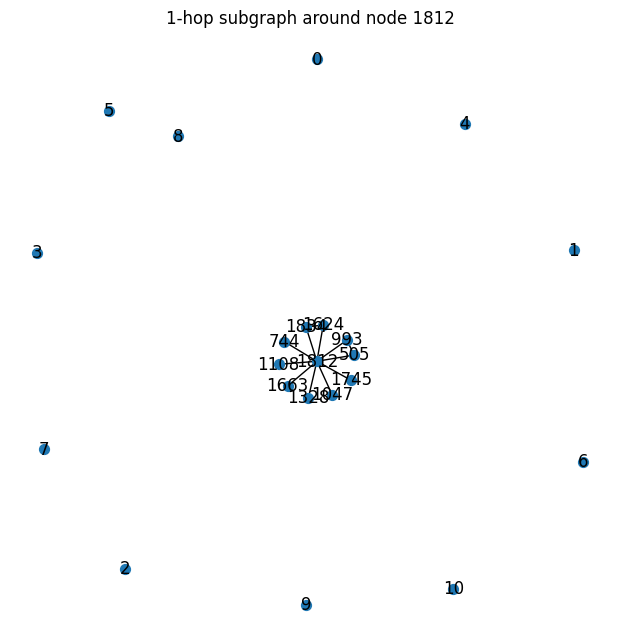

In [ ]:
# === CELL 13: Extract top suspicious nodes and export subgraph (visualization hook) ===
# Choose the model to inspect: hybrid or sage
use_probs = None
hybrid.eval(); sage.eval()
with torch.no_grad():
    out_h, _ = hybrid(data_static.x.to(device), data_static.edge_index.to(device), seq_tensor.to(device))
    probs_h = torch.softmax(out_h, dim=1)[:,1].cpu().numpy()
    logits_sage = sage(data_static.x.to(device), data_static.edge_index.to(device))
    probs_s = torch.softmax(logits_sage, dim=1)[:,1].cpu().numpy()

df_rank_h = pd.DataFrame({"node": np.arange(n_nodes), "prob_hybrid":probs_h, "prob_sage":probs_s, "label": y_nodes.cpu().numpy()})
df_rank_h = df_rank_h.sort_values("prob_hybrid", ascending=False)
print("Top suspicious (hybrid):")
display(df_rank_h.head(10))

# Build 1-hop subgraph around top node
top_node = int(df_rank_h.iloc[0]['node'])
subset, edge_index_sub, mapping, edge_mask = k_hop_subgraph(top_node, 1, data_static.edge_index, relabel_nodes=False)
sub_nodes = subset.cpu().numpy()
print("Subgraph nodes:", sub_nodes[:20])
# Export to networkx
sub_data = Data(x=data_static.x[sub_nodes], edge_index=edge_index_sub)
Gsub = to_networkx(sub_data, to_undirected=True)
plt.figure(figsize=(6,6))
pos = nx.spring_layout(Gsub, seed=42)
nx.draw(Gsub, pos, node_size=50, with_labels=True)
plt.title(f"1-hop subgraph around node {top_node}")
plt.show()


In [ ]:
# === CELL 14: Save models & artifacts (optional) ===
os.makedirs("models", exist_ok=True)
torch.save(hybrid.state_dict(), "models/hybrid_demo.pt")
torch.save(sage.state_dict(), "models/sage_demo.pt")
torch.save(ae.state_dict(), "models/lstm_ae.pt")
print("Saved model checkpoints to ./models")


Saved model checkpoints to ./models


In [ ]:
# === CELL 15: Optional — Streamlit demo hook (commented) ===
# Running Streamlit inside Colab is possible but has caveats (ngrok/token etc).
# Below is a minimal Streamlit app string you could write to file and run locally or inside Colab with ngrok.
# For brevity this is just illustrative; uncomment/run at your own convenience.

"""
%%bash --no-run
cat > streamlit_demo.py <<'PY'
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objects as go

st.title("Hybrid GNN + Temporal Fraud Demo (summary)")
# load precomputed files saved above if available
try:
    df_rank = pd.read_csv('df_rank_h.csv')
    st.dataframe(df_rank.head(50))
except:
    st.info("Run training cells to produce ranking.")
PY
"""
print("Streamlit demo hook created (commented). Run locally by moving 'streamlit_demo.py' to your machine and running 'streamlit run streamlit_demo.py'.")


Streamlit demo hook created (commented). Run locally by moving 'streamlit_demo.py' to your machine and running 'streamlit run streamlit_demo.py'.
